# CycleGAN

In this notebook, we will implement [CycleGAN](https://arxiv.org/abs/1703.10593) by Zhu et al. 2017.

You will be training a model that can convert horses into zebras, and vice versa.


## Getting Started

Step 1: We will start by importing some necessary libraries.

In [1]:
import torch
from torch import nn
from tqdm import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import glob
import random
import os
from torch.utils.data import Dataset
from PIL import Image
import requests
import zipfile
import io
import torch.nn.functional as F
import torchvision

Step 2: Below code downloads the zebra2horses dataset and place it in same folder.

In [3]:

# URL of the dataset
# url = 'https://efrosgans.eecs.berkeley.edu/cyclegan/datasets/horse2zebra.zip'
url = 'https://huggingface.co/datasets/kerls/cyclegan-horse2zebra/resolve/main/horse2zebra.zip'

# Send a GET request to the URL
response = requests.get(url)

# Ensure the request is successful
if response.status_code == 200:
    z = zipfile.ZipFile(io.BytesIO(response.content))
    z.extractall()  # You can specify a different directory inside the parentheses
    print("Download and extraction complete.")
else:
    print("Error downloading the file. Status code:", response.status_code)


Download and extraction complete.


Step 3: Define our Custom dataset class function and transforms

In [5]:
# Inspired by https://github.com/aitorzip/PyTorch-CycleGAN/blob/master/datasets.py
class ImageDataset(Dataset):
    def __init__(self, root, transform=None, mode='train'):
        self.transform = transform
        self.files_A = sorted(glob.glob(os.path.join(root, '%sA' % mode) + '/*.*'))
        self.files_B = sorted(glob.glob(os.path.join(root, '%sB' % mode) + '/*.*'))
        if len(self.files_A) > len(self.files_B):
            self.files_A, self.files_B = self.files_B, self.files_A
        self.new_perm()
        assert len(self.files_A) > 0, "Make sure you downloaded the horse2zebra images!"

    def new_perm(self):
        self.randperm = torch.randperm(len(self.files_B))[:len(self.files_A)]

    def __getitem__(self, index):
        item_A = self.transform(Image.open(self.files_A[index % len(self.files_A)]))
        item_B = self.transform(Image.open(self.files_B[self.randperm[index]]))
        if item_A.shape[0] != 3:
            item_A = item_A.repeat(3, 1, 1)
        if item_B.shape[0] != 3:
            item_B = item_B.repeat(3, 1, 1)
        if index == len(self) - 1:
            self.new_perm()
        # Old versions of PyTorch didn't support normalization for different-channeled images
        return (item_A - 0.5) * 2, (item_B - 0.5) * 2

    def __len__(self):
        return min(len(self.files_A), len(self.files_B))

In [6]:
load_shape = 286
target_shape = 256

# basic transforms
transform = transforms.Compose([
    transforms.Resize(load_shape),
    transforms.RandomCrop(target_shape),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

import torchvision
dataset = ImageDataset("horse2zebra", transform=transform)

In [7]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_shifted = image_tensor
    image_unflat = image_shifted.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

![CycleGAN](https://huggingface.co/datasets/hf-vision/course-assets/resolve/main/cycleGAN1.jpg)

## Generator

CycleGAN generator is composed of encoding blocks, residual blocks, and then decoding blocks.

### Residual Block:
These blocks add the output of convolutional layers to the input, enabling minimal changes to the image. This method acts as a skip connection, facilitating deeper networks by mitigating vanishing gradients and allowing the learning of more complex features.

In [8]:
class ResidualBlock(nn.Module):
    '''
    Defines a residual block for a neural network.

    This block consists of two convolutional layers with instance normalization,
    followed by an activation function. The input is added to the output of
    these layers, forming the final output of the block.
    '''

    def __init__(self, input_channels):
        '''
        Initializes the ResidualBlock.

        Parameters:
        input_channels (int): Number of channels in the input tensor.
        '''
        super(ResidualBlock, self).__init__()

        # First convolutional layer with reflective padding
        self.conv1 = nn.Conv2d(input_channels, input_channels, kernel_size=3, padding=1, padding_mode="reflect")

        # Second convolutional layer with reflective padding
        self.conv2 = nn.Conv2d(input_channels, input_channels, kernel_size=3, padding=1, padding_mode="reflect")

        # Instance normalization layer
        self.instancenorm = nn.InstanceNorm2d(input_channels)

        # Activation function (ReLU)
        self.activation = nn.ReLU()

    def forward(self, x):
        '''
        Defines the forward pass of the ResidualBlock.

        Parameters:
        x (Tensor): Input tensor to the residual block.

        Returns:
        Tensor: Output tensor after applying the residual block operations.
        '''
        # Save the original input for use in the skip connection
        original_tensor_image = x.clone()

        # First convolutional operation
        x = self.conv1(x)
        x = self.instancenorm(x)
        x = self.activation(x)

        # Second convolutional operation
        x = self.conv2(x)
        x = self.instancenorm(x)

        # Add the original tensor to the output (skip connection)
        return original_tensor_image + x



### Encoder and Decoder Blocks

In [9]:
class EncoderBlock(nn.Module):
    '''
    EncoderBlock Class:
    A class used to create an encoder block in a neural network, which consists of a convolutional layer,
    an optional instance normalization layer, and an activation function.
    Attributes:
        conv1: Conv2d layer to reduce spatial dimensions and increase channels.
        instancenorm: InstanceNorm2d layer for normalization (optional).
        activation: Activation function (ReLU or LeakyReLU).
        use_bn: Boolean, whether to use batch normalization.
    '''

    def __init__(self, input_channels, use_bn=True, kernel_size=3, activation='relu'):
        super(EncoderBlock, self).__init__()
        # Create a convolutional layer with stride 2 for downsampling
        self.conv1 = nn.Conv2d(input_channels, input_channels * 2, kernel_size=kernel_size, padding=1, stride=2, padding_mode='reflect')
        # Choose activation function based on the input argument
        if activation == 'relu':
            self.activation = nn.ReLU()
        else:
            self.activation = nn.LeakyReLU(0.2)
        # Add instance normalization if use_bn is True
        if use_bn:
            self.instancenorm = nn.InstanceNorm2d(input_channels * 2)

        self.use_bn = use_bn

    def forward(self, x):
        '''
        Function for the forward pass of EncoderBlock:
        Applies a convolution, optional normalization, and activation to the input tensor.
        '''
        x = self.conv1(x)
        if self.use_bn:
            x = self.instancenorm(x)
        x = self.activation(x)
        return x

class DecoderBlock(nn.Module):
    '''
    DecoderBlock Class:
    A class used to create a decoder block in a neural network, which consists of a transposed convolutional layer
    (for upsampling), an optional instance normalization layer, and a ReLU activation function.
    Attributes:
        conv1: ConvTranspose2d layer for upsampling and reducing channels.
        instancenorm: InstanceNorm2d layer for normalization (optional).
        use_bn: Boolean, whether to use batch normalization.
        activation: ReLU activation function.
    '''

    def __init__(self, input_channels, use_bn=True):
        super(DecoderBlock, self).__init__()
        # Transposed convolutional layer for upsampling
        self.conv1 = nn.ConvTranspose2d(input_channels, input_channels // 2, kernel_size=3, stride=2, padding=1, output_padding=1)
        # Add instance normalization if use_bn is True
        if use_bn:
            self.instancenorm = nn.InstanceNorm2d(input_channels // 2)
        self.use_bn = use_bn
        # ReLU activation function
        self.activation = nn.ReLU()

    def forward(self,x):
        '''
        Function for the forward pass of DecoderBlock:
        Applies a transposed convolution, optional normalization, and activation to the input tensor.
        '''
        x = self.conv1(x)
        if self.use_bn:
            x = self.instancenorm(x)
        x = self.activation(x)
        return x

class FeatureMapBlock(nn.Module):
    '''
    FeatureMapBlock Class:
    A class for a basic convolutional block used to modify the number of feature maps
    without changing the spatial dimensions of the input.
    Attributes:
        conv: Conv2d layer with a large kernel size to capture features without reducing spatial size.
    '''

    def __init__(self, input_channels, output_channels):
        super(FeatureMapBlock, self).__init__()
        # Convolutional layer with a larger kernel size for feature mapping
        self.conv = nn.Conv2d(input_channels, output_channels, kernel_size=7, padding=3, padding_mode='reflect')

    def forward(self, x):
        '''
        Function for the forward pass of FeatureMapBlock:
        Applies a convolution to the input tensor to change the number of feature maps.
        '''
        x = self.conv(x)
        return x


## CycleGAN Generator
Now, let's put all the blocks together to create your CycleGAN Generator

In [10]:
class Generator(nn.Module):

    def __init__(self, input_channels, output_channels, hidden_channels=64):
        super(Generator, self).__init__()

        self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
        self.encoder1 = EncoderBlock(hidden_channels)
        self.encoder2 = EncoderBlock(hidden_channels * 2)

        res_mult = 4
        self.res0 = ResidualBlock(hidden_channels * res_mult)
        self.res1 = ResidualBlock(hidden_channels * res_mult)
        self.res2 = ResidualBlock(hidden_channels * res_mult)
        self.res3 = ResidualBlock(hidden_channels * res_mult)
        self.res4 = ResidualBlock(hidden_channels * res_mult)
        self.res5 = ResidualBlock(hidden_channels * res_mult)
        self.res6 = ResidualBlock(hidden_channels * res_mult)
        self.res7 = ResidualBlock(hidden_channels * res_mult)
        self.res8 = ResidualBlock(hidden_channels * res_mult)

        self.decoder1 = DecoderBlock(hidden_channels * 4)
        self.decoder2 = DecoderBlock(hidden_channels * 2)

        self.downfeature = FeatureMapBlock(hidden_channels, output_channels)
        self.tanh = torch.nn.Tanh()

    def forward(self, x):
        x0 = self.upfeature(x)
        x1 = self.encoder1(x0)
        x2 = self.encoder2(x1)
        x3 = self.res0(x2)
        x4 = self.res1(x3)
        x5 = self.res2(x4)
        x6 = self.res3(x5)
        x7 = self.res4(x6)
        x8 = self.res5(x7)
        x9 = self.res6(x8)
        x10 = self.res7(x9)
        x11 = self.res8(x10)
        x12 = self.decoder1(x11)
        x13 = self.decoder2(x12)
        xn = self.downfeature(x13)
        return self.tanh(xn)

## Discriminator Block
Now we will define the discriminator block

In [12]:
class Discriminator(nn.Module):
    '''
    Discriminator Class:
    Defines a discriminator network for a generative model, such as a GAN.
    The discriminator's role is to distinguish between real and fake (generated) data.

    Attributes:
        input_channels (int): Number of input channels (e.g., for an RGB image, it would be 3).
        hidden_channels (int): Base number of channels used in the network, which scales up in deeper layers.
    '''
    def __init__(self, input_channels, hidden_channels=64):
        super(Discriminator, self).__init__()

        # Initial feature mapping to scale up the number of channels
        self.upfeature = FeatureMapBlock(input_channels, hidden_channels)

        # Contracting blocks (Encoder blocks) - reduce spatial dimensions and increase channel depth
        # Using LeakyReLU activation (lrelu) for each contracting block
        self.contract1 = EncoderBlock(hidden_channels, use_bn=False, kernel_size=4, activation='lrelu')
        self.contract2 = EncoderBlock(hidden_channels * 2, kernel_size=4, activation='lrelu')
        self.contract3 = EncoderBlock(hidden_channels * 4, kernel_size=4, activation='lrelu')

        # Final convolution to output a single channel (binary classification for real or fake)
        self.final = nn.Conv2d(hidden_channels * 8, 1, kernel_size=1)

    def forward(self, x):
        '''
        Defines the forward pass of the discriminator.
        '''
        # Sequentially apply feature mapping and contracting blocks
        x0 = self.upfeature(x)
        x1 = self.contract1(x0)
        x2 = self.contract2(x1)
        x3 = self.contract3(x2)

        # Apply the final convolution
        xn = self.final(x3)
        return xn


## Training Preperation

Now you can put everything together for training! You will start by defining your parameters:

  *   adv_criterion: an adversarial loss function to keep track of how well the GAN is fooling the discriminator and how well the discriminator is catching the GAN
  *   recon_criterion: a loss function that rewards similar images to the ground truth, which "reconstruct" the image
  *   n_epochs: the number of times you iterate through the entire dataset when training
  *   dim_A: the number of channels of the images in pile A
  *   dim_B: the number of channels of the images in pile B (note that in the visualization this is currently treated as equivalent to dim_A)
  *   display_step: how often to display/visualize the images
  *   batch_size: the number of images per forward/backward pass
  *   lr: the learning rate
  *   target_shape: the size of the input and output images (in pixels)
  *   load_shape: the size for the dataset to load the images at before randomly cropping them to target_shape as a simple data augmentation
  *   device: the device type

In [13]:
adv_criterion = nn.MSELoss()
recon_criterion = nn.L1Loss()
device = 'cuda'
n_epochs = 20
dim_A = 3
dim_B = 3
display_step = 200
batch_size = 1
lr = 0.0002

Next, you can initialize your generators and discriminators, as well as their optimizers. For CycleGAN, you will have two generators and two discriminators since there are two GANs:

*   Generator for horse to zebra (`gen_AB`)
*   Generator for zebra to horse (`gen_BA`)
*   Discriminator for horse (`disc_A`)
*   Discriminator for zebra (`disc_B`)

In [14]:
gen_AB = Generator(dim_A, dim_B).to(device)
gen_BA = Generator(dim_B, dim_A).to(device)
gen_opt = torch.optim.Adam(list(gen_AB.parameters()) + list(gen_BA.parameters()), lr=lr, betas=(0.5, 0.999))
disc_A = Discriminator(dim_A).to(device)
disc_A_opt = torch.optim.Adam(disc_A.parameters(), lr=lr, betas=(0.5, 0.999))
disc_B = Discriminator(dim_B).to(device)
disc_B_opt = torch.optim.Adam(disc_B.parameters(), lr=lr, betas=(0.5, 0.999))

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

# Training the model from scratch
gen_AB = gen_AB.apply(weights_init)
gen_BA = gen_BA.apply(weights_init)
disc_A = disc_A.apply(weights_init)
disc_B = disc_B.apply(weights_init)

## CycleGAN Lossses

Now We will define all the losses required for the CycleGAN:

*   Discriminator Loss
*   Generator Loss
*   Identity Loss
*   Cycle Consistency Loss

### Discriminator Loss

#### Arguments:
  - real_X: Real images from the dataset.
  - fake_X: Fake images generated by the generator.
  - disc_X: The discriminator network.
  - adv_criterion: The adversarial loss function (usually binary cross-entropy).

#### Returns:
  - disc_loss: The calculated loss for the discriminator.

In [15]:
def get_disc_loss(real_X, fake_X, disc_X, adv_criterion):
    '''
    Calculate the discriminator's loss.
    '''

    # Pass fake images through discriminator and calculate loss against zeros
    disc_fake = disc_X(fake_X)
    # The discriminator should output close to 0 for fake images
    disc_fake_loss = adv_criterion(disc_fake, torch.zeros_like(disc_fake))

    # Pass real images through discriminator and calculate loss against ones
    disc_real = disc_X(real_X)
    # The discriminator should output close to 1 for real images
    disc_real_loss = adv_criterion(disc_real, torch.ones_like(disc_real))

    # Average the fake and real loss
    disc_loss = (disc_fake_loss + disc_real_loss) / 2

    return disc_loss


### Generator Loss

Calculate the generator's adversarial loss.

####Arguments:
- real_X: Real images from domain X.
- disc_Y: The discriminator for domain Y.
- gen_XY: The generator that converts images from domain X to domain Y.
- adv_criterion: The adversarial loss function (usually binary cross-entropy).

####Returns:
- adversarial_loss: The calculated adversarial loss for the generator.
- fake_Y: The generated images, transformed from domain X to domain Y.
    

In [16]:
def get_gen_adversarial_loss(real_X, disc_Y, gen_XY, adv_criterion):
    '''
    Calculate the generator's adversarial loss.
    '''

    # Generate fake images in domain Y using the generator
    fake_Y = gen_XY(real_X)

    # Pass these fake images through the discriminator for domain Y
    fake_disc_Y = disc_Y(fake_Y)

    # Calculate the loss against ones
    # The generator wants to fool the discriminator, so it aims for discriminator outputs close to 1
    adversarial_loss = adv_criterion(fake_disc_Y, torch.ones_like(fake_disc_Y))

    # Return the adversarial loss and the generated images
    return adversarial_loss, fake_Y


### Identity Loss

The identity loss in CycleGAN measures how much a generator changes an image from the target domain when it should ideally output the same image unchanged. For example, passing a horse image to a zebra-to-horse generator should result in the same horse image, as the generator's task is unnecessary. This loss helps maintain image characteristics like color, especially in transformations where the input and target domains are similar, such as photos to paintings. Encouraging this identity mapping can improve the model's performance in specific applications by ensuring it doesn't apply unnecessary transformations.

#### Description
- This function computes the identity loss, which measures how much the generator gen_YX alters an input from its target domain (real_X). The ideal behavior for the generator is to leave the input unchanged if it already belongs to the target domain.

####Parameters:
- real_X (Tensor): A batch of real images from the target domain.
- gen_YX (Module): The generator model that should ideally perform no transformation on the input images from the target domain.
- identity_criterion (Loss Function): The loss function used to compute the identity loss.

####Returns:
- Tuple[Tensor, Tensor]: A tuple containing the identity loss and the generated images (which ideally should be identical to the input images).

In [17]:
def get_identity_loss(real_X, gen_YX, identity_criterion):
    '''
    Calculates the identity loss for a generator.
    '''

    # Pass the real images from the target domain through the generator
    identity_X = gen_YX(real_X)

    # Calculate the identity loss, which is the difference between the generator's output
    # and the original images. The loss is lower when the generator alters the images less.
    identity_loss = identity_criterion(real_X, identity_X)

    return identity_loss, identity_X


### Cycle Consistency Loss
The cycle consistency loss in CycleGAN ensures that an image, when passed through a generator to another domain and then back to its original domain using a reverse generator, remains the same as the original. This loss encourages information preservation through the cycle of transformations.


#### Parameters:
- real_X (Tensor): The original images from domain X.
- fake_Y (Tensor): The transformed images, originally from domain X, now in domain Y.
- gen_YX (Module): The generator model that transforms images from domain Y back to domain X.
- cycle_criterion (Loss Function): The criterion (loss function) used to evaluate cycle consistency.

#### Returns:
- tuple: Contains the cycle loss (a scalar Tensor) and the cycled images (cycle_X).

In [18]:
def get_cycle_consistency_loss(real_X, fake_Y, gen_YX, cycle_criterion):
    '''
    Calculate the cycle consistency loss for a pair of images.
    '''

    # Transform the fake images from domain Y back to domain X
    cycle_X = gen_YX(fake_Y)

    # Calculate the cycle consistency loss (how close is cycle_X to the original real_X)
    cycle_loss = cycle_criterion(real_X, cycle_X)

    return cycle_loss, cycle_X


### Get Generator Loss
#### Parameters:
- real_A: the real images from pile A
- real_B: the real images from pile B
- gen_AB: the generator for class A to B; takes images and returns the images transformed to class B
- gen_BA: the generator for class B to A; takes images and returns the images transformed to class A
- disc_A: the discriminator for class A; takes images and returns real/fake class A prediction matrices
- disc_B: the discriminator for class B; takes images and returns real/fake class B prediction matrices
- adv_criterion: the adversarial loss function; takes the discriminator predictions and the true labels and returns a adversarial loss (which you aim to minimize)
- identity_criterion: the reconstruction loss function used for identity loss and cycle consistency loss; takes two sets of images and returns their pixel differences (which you aim to minimize)
- cycle_criterion: the cycle consistency loss function; takes the real images from X and those images put through a X->Y generator and then Y->X generator and returns the cycle consistency loss (which you aim to minimize). Note that in practice, cycle_criterion == identity_criterion == L1 loss
- lambda_identity: the weight of the identity loss
- lambda_cycle: the weight of the cycle-consistency loss

In [19]:
def get_gen_loss(real_A, real_B, gen_AB, gen_BA, disc_A, disc_B, adv_criterion, identity_criterion, cycle_criterion, lambda_identity=0.1, lambda_cycle=10):
    '''
    Return the loss of the generator given inputs.
    '''

    # Adversarial Loss -- get_gen_adversarial_loss(real_X, disc_Y, gen_XY, adv_criterion)
    adversarial_loss_AB, fake_B =  get_gen_adversarial_loss(real_A,disc_B,gen_AB,adv_criterion)
    adversarial_loss_BA, fake_A =  get_gen_adversarial_loss(real_B,disc_A,gen_BA,adv_criterion)
    adversarial_loss = adversarial_loss_AB + adversarial_loss_BA
    # Identity Loss -- get_identity_loss(real_X, gen_YX, identity_criterion)
    identity_loss_A, _ = get_identity_loss(real_A, gen_BA, identity_criterion)
    identity_loss_B, _ = get_identity_loss(real_B, gen_AB, identity_criterion)
    identity_loss = identity_loss_A + identity_loss_B
    # Cycle-consistency Loss -- get_cycle_consistency_loss(real_X, fake_Y, gen_YX, cycle_criterion)
    cycle_consistency_loss_BA, _ = get_cycle_consistency_loss(real_A, fake_B, gen_BA, cycle_criterion)
    cycle_consistency_loss_AB, _ = get_cycle_consistency_loss(real_B, fake_A, gen_AB, cycle_criterion)
    cycle_consistency_loss = cycle_consistency_loss_BA + cycle_consistency_loss_AB
    # Total loss
    gen_loss = adversarial_loss + lambda_identity * identity_loss + lambda_cycle * cycle_consistency_loss

    return gen_loss, fake_A, fake_B

### CycleGAN Training

  0%|          | 0/1067 [00:00<?, ?it/s]

Epoch 0: Step 0: Generator (U-Net) loss: 0.027489018440246583, Discriminator loss: 0.001290176212787628


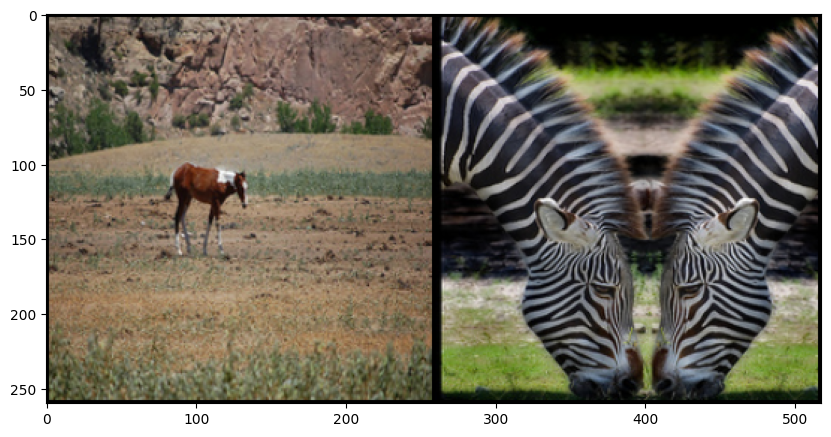

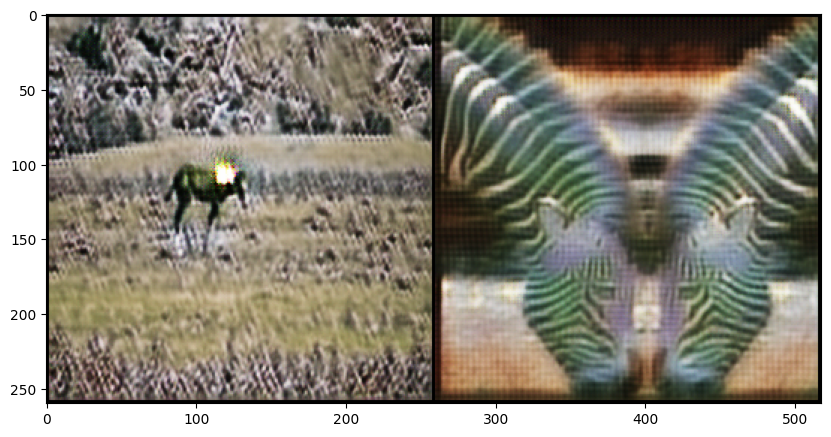

  3%|▎         | 31/1067 [00:46<25:52,  1.50s/it]


KeyboardInterrupt: 

In [31]:
from skimage import color
import numpy as np
plt.rcParams["figure.figsize"] = (10, 10)


def train(save_model=False):
    mean_generator_loss = 0
    mean_discriminator_loss = 0
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    cur_step = 0

    for epoch in range(n_epochs):
        # Dataloader returns the batches
        # for image, _ in tqdm(dataloader):
        for real_A, real_B in tqdm(dataloader):
            real_A = nn.functional.interpolate(real_A, size=target_shape)
            real_B = nn.functional.interpolate(real_B, size=target_shape)
            cur_batch_size = len(real_A)
            real_A = real_A.to(device)
            real_B = real_B.to(device)

            ### Update discriminator A ###
            disc_A_opt.zero_grad() # Zero out the gradient before backpropagation
            with torch.no_grad():
                fake_A = gen_BA(real_B)
            disc_A_loss = get_disc_loss(real_A, fake_A, disc_A, adv_criterion)
            disc_A_loss.backward(retain_graph=True) # Update gradients
            disc_A_opt.step() # Update optimizer

            ### Update discriminator B ###
            disc_B_opt.zero_grad() # Zero out the gradient before backpropagation
            with torch.no_grad():
                fake_B = gen_AB(real_A)
            disc_B_loss = get_disc_loss(real_B, fake_B, disc_B, adv_criterion)
            disc_B_loss.backward(retain_graph=True) # Update gradients
            disc_B_opt.step() # Update optimizer

            ### Update generator ###
            gen_opt.zero_grad()
            gen_loss, fake_A, fake_B = get_gen_loss(
                real_A, real_B, gen_AB, gen_BA, disc_A, disc_B, adv_criterion, recon_criterion, recon_criterion
            )
            gen_loss.backward() # Update gradients
            gen_opt.step() # Update optimizer

            # Keep track of the average discriminator loss
            mean_discriminator_loss += disc_A_loss.item() / display_step
            # Keep track of the average generator loss
            mean_generator_loss += gen_loss.item() / display_step

            ### Visualization code ###
            if cur_step % display_step == 0:
                print(f"Epoch {epoch}: Step {cur_step}: Generator (U-Net) loss: {mean_generator_loss}, Discriminator loss: {mean_discriminator_loss}")
                show_tensor_images(torch.cat([real_A, real_B]), size=(dim_A, target_shape, target_shape))
                show_tensor_images(torch.cat([fake_B, fake_A]), size=(dim_B, target_shape, target_shape))
                mean_generator_loss = 0
                mean_discriminator_loss = 0
            cur_step += 1

        if save_model:
          torch.save(gen_AB.state_dict(), 'gen_AB.pth')
          torch.save(gen_BA.state_dict(), 'gen_BA.pth')
          torch.save(disc_A.state_dict(), 'disc_A.pth')
          torch.save(disc_B.state_dict(), 'disc_B.pth')


train(save_model=True)

### Upload the model to Huggingface!

In [32]:

!huggingface-cli login

from huggingface_hub import HfApi
api = HfApi()

# Create a Huggingface model repo and use the name here
repo_name = "kerls/cyclegan-horsetozebra"

# api.upload_folder(
#     folder_path="/pth",
#     repo_id=repo_name,
#     repo_type="model",
# )

api.upload_file(
    path_or_fileobj="gen_AB.pth",
    path_in_repo="gen_AB.pth",
    repo_id=repo_name,
    repo_type="model",
)
api.upload_file(
    path_or_fileobj="gen_BA.pth",
    path_in_repo="gen_BA.pth",
    repo_id=repo_name,
    repo_type="model",
)
api.upload_file(
    path_or_fileobj="disc_A.pth",
    path_in_repo="disc_A.pth",
    repo_id=repo_name,
    repo_type="model",
)
api.upload_file(
    path_or_fileobj="disc_B.pth",
    path_in_repo="disc_B.pth",
    repo_id=repo_name,
    repo_type="model",
)


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) 
Token is valid (permission: write).
Cannot authenticate through git-creden

gen_AB.pth:   0%|          | 0.00/45.5M [00:00<?, ?B/s]

gen_BA.pth:   0%|          | 0.00/45.5M [00:00<?, ?B/s]

disc_A.pth:   0%|          | 0.00/11.1M [00:00<?, ?B/s]

disc_B.pth:   0%|          | 0.00/565k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/kerls/cyclegan-horsetozebra/commit/2abe20c18633517bd04c50fe5024e3a59fb8152a', commit_message='Upload disc_B.pth with huggingface_hub', commit_description='', oid='2abe20c18633517bd04c50fe5024e3a59fb8152a', pr_url=None, pr_revision=None, pr_num=None)